# TinyGPT

**Author: Abraham R.**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Downloading Dataset

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Character-based encoding

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# Train/test split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Dataloaders

In [4]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# GPT Configuration

In [5]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = 4
    num_experts_per_token : int = 1

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    # ff_class: Optional[Type[nn.Module]] = None
    ff_class: Optional[Type] = None
    moe_args: Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe_args': None}


In [6]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        # pin_memory=True,
                        num_workers= 0, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        # pin_memory=True,
                        num_workers= 0,
                        )

In [7]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [9]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## TinyGPT Architecture

In [10]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


## Generation function (inference)

In [11]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Setup

In [12]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
# model = torch.compile(m)
model = TinyGPT(config).to(device) # Direct init (compilation not needed when on MPS)


In [13]:
# Quick MPS Verification

print(f"Device: {device}")  # Should be 'mps'
print(f"MPS available: {torch.backends.mps.is_available()}")  # True
print(f"MPS built: {torch.backends.mps.is_built()}")  # True

# Generate a small tensor on MPS to test
test_tensor = torch.randn(10, device='mps')
print(test_tensor)  # Should print without error

Device: mps
MPS available: True
MPS built: True
tensor([ 0.9262, -1.0897,  1.0379,  1.5227,  0.0659, -0.0127, -1.1891, -0.8748,
         0.4683,  0.8133], device='mps:0')


In [14]:
device

'mps'

In [15]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

# Training

In [16]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500,
)
# Training
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")
    

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/Users/ari/opt/miniconda3/envs/nlp2-env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)
loss 2.13358: 100%|██████████| 11246/11246 [05:57<00:00, 31.45it/s]


Epoch 1 training loss: 2.1141


val_loss 2.10994: 100%|██████████| 1246/1246 [00:09<00:00, 130.78it/s]


Epoch 1 validation loss: 2.0659


loss 2.08228: 100%|██████████| 11246/11246 [05:43<00:00, 32.77it/s]


Epoch 2 training loss: 2.1147


val_loss 2.10995: 100%|██████████| 1246/1246 [00:08<00:00, 140.69it/s]


Epoch 2 validation loss: 2.0659


loss 2.19246: 100%|██████████| 11246/11246 [05:44<00:00, 32.64it/s]


Epoch 3 training loss: 2.1595


val_loss 2.10995: 100%|██████████| 1246/1246 [00:08<00:00, 139.65it/s]


Epoch 3 validation loss: 2.0659


loss 2.10938: 100%|██████████| 11246/11246 [05:45<00:00, 32.57it/s]


Epoch 4 training loss: 2.0927


val_loss 2.10995: 100%|██████████| 1246/1246 [00:09<00:00, 136.84it/s]


Epoch 4 validation loss: 2.0659


loss 2.08847: 100%|██████████| 11246/11246 [05:47<00:00, 32.35it/s]


Epoch 5 training loss: 2.0969


val_loss 2.10995: 100%|██████████| 1246/1246 [00:09<00:00, 138.29it/s]


Epoch 5 validation loss: 2.0659


loss 2.14692: 100%|██████████| 11246/11246 [05:42<00:00, 32.87it/s]


Epoch 6 training loss: 2.1024


val_loss 2.10995: 100%|██████████| 1246/1246 [00:09<00:00, 138.29it/s]


Epoch 6 validation loss: 2.0659


loss 2.07460: 100%|██████████| 11246/11246 [05:40<00:00, 33.01it/s]


Epoch 7 training loss: 2.1214


val_loss 2.10995: 100%|██████████| 1246/1246 [00:08<00:00, 143.21it/s]


Epoch 7 validation loss: 2.0659


loss 2.10336: 100%|██████████| 11246/11246 [06:11<00:00, 30.31it/s]


Epoch 8 training loss: 2.1022


val_loss 2.10995: 100%|██████████| 1246/1246 [00:10<00:00, 115.20it/s]


Epoch 8 validation loss: 2.0659


loss 2.12773: 100%|██████████| 11246/11246 [06:21<00:00, 29.51it/s]


Epoch 9 training loss: 2.1163


val_loss 2.10995: 100%|██████████| 1246/1246 [00:10<00:00, 123.43it/s]


Epoch 9 validation loss: 2.0659


loss 2.15165: 100%|██████████| 11246/11246 [05:55<00:00, 31.59it/s]


Epoch 10 training loss: 2.1393


val_loss 2.10995: 100%|██████████| 1246/1246 [00:08<00:00, 140.19it/s]


Epoch 10 validation loss: 2.0659
Training complete.


### Quick test (Inference)

In [17]:
generate("To be", max_new_tokens=100,use_cache=True) 

"To berchikle.\n\nWelond Con, gI 'ind to Ton.\n\nBRUS:\nVI pan utit wer swell mot--\nIUS:\nwe theand yo\nmace be b"

# Task I

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [18]:
# # TODO Implement Greedy decoding, Temperature and top_k/top_p
# @torch.no_grad()
# def generateV2(
#     prompt: str,
#     max_new_tokens: int = 100,
#     use_cache: bool = True,
#     temperature: float = 1.0,
#     top_k: int = 10,
#     top_p: float = 0.9,
# )-> Optional[str]:

#     return None

In [19]:
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 0,
    top_p: float = 1.0,
    model = None,
) -> Optional[str]:
    if model is None:
        raise ValueError("Missing model input argument!")
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Prepare input
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # Forward
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :] / temperature  # Apply temperature

        # Top-k filtering
        if top_k > 0:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('inf')

        # Top-p (nucleus) filtering
        if top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cum_probs > top_p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            logits[indices_to_remove] = -float('inf')

        # Sampling
        probs = F.softmax(logits, dim=-1)
        if temperature == 0 or top_k == 1:  # Greedy
            next_token = torch.argmax(probs, dim=-1, keepdim=True)
        else:
            next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Compare generate vs generateV2

Add your comments and findings

In [20]:
# Result 1
generate("To be", max_new_tokens=100, use_cache=True)


'To be madins ileably.\n\nARCOLAy?\n\nHit COMNIUSit:\nWherust IUpours sle taplotlese\nHed. Atizer; malisset:\nWha'

Hago algunas pruebas para ver los efectos de los distintos parámetros de generación:

In [22]:
# Greedy (picks the most likely token)
generateV2("To be", temperature=0.0, model=model)

'To be\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [23]:
# Temperature (the higher the temperature, the more random the output)
generateV2("To be", model=model, temperature=0.7)

"To be benot than the fir woh articof thalls!\n\nMENENENIUS:\nThe he this hom torne to; monse the to' the pro"

In [25]:
# Temperature (the higher the temperature, the more random the output)
generateV2("To be", model=model, temperature=1.7)

"To been'chabll: hin: ous,\nIn ?oullq:r t;l, hid-\nTham:\nghn, ganof Mre, ils giflvonencs ourd on ainsk\nAg, c"

In [24]:
# Top-k (Only sample from the top k most likely tokens)
generateV2("To be", model=model, top_k=50)

'To beve.\n\nDENIUS:\nI, areeve tard:\nFo deralre the noo cond or shere on gad thivus st iwoly! thet\nBenchend '

In [ ]:
# Top-p (nucleus) - (Dynamic filtering: Only sample from the smallest set of tokens with cumulative probability >= top_p)
generateV2("To be", model = model, top_p=0.9)

'To ben the hiold he prim your the athee win the them, arterears surour\nHancke stond forive nener\nThis and'

In [ ]:
# Combined
generateV2("To be", model=model, temperature=0.8, top_k=40, top_p=0.95)

"To be's cof whand ha sis, the hand crall theald to mate hit efuld\nwir con hay your wou dioncon thend\nMENE"

### Task I -  conclusiones: 

El modelo entrega una performance pobre (es muy pequeño, con aprox. 10M parámetros), está entrenado con muy pocos datos (100k caracteres), durante pocas épocas (2) y hace uso de un tokenizer a nivel de caracter y no de subpalabra. 

Se hicieron varias pruebas solo con la función $\texttt{generateV2}$ para analizar los efectos de cada parámetro por separado. Con estas pruebas no se aprecian fuertemente sus efectos dada la baja performance del modelo, pero se puede notar lo siguiente:

* Ninguna de las pruebas genera oraciones coherentes.

* La temperatura en 0 genera una salida repetitiva y menos creativa, peor que la entregada por la función de generación original. Esto es algo que tiene sentido ya que siempre elige la palabra más probable. El tokenizer tiene "\n" como token válido y es probablemente lo que más se repite.

* Con una temperatura más alta (pero <0.1), se observa que la salida es más variada, aunque todavía se presentan algunas repeticiones.

* Usando Temp = 1.7 (>1.5) la salida pierde aún más el sentido - ya no se distingue ninguna palabra.

* Con top-k se observan intentos de aparición puntuación y una salida más variada.

* Con top-p la salida parece ser un poco más estructurada que por ejemplo con solo temperatura.

* La función combinada genera algo se ameja más a una oración, y parece ser la mejor salida observada. Muestra aspectos de puntuación, estructura y variedad, pero sigue siendo incoherente en general. Se puede pensar que combinar los métodos ayuda a mejorar la calidad de la salida, incluso en este caso de un modelo muy pequeño y sub-entrenado.

---

## Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [26]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return self.net(x)  # Apply the MLP


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe_args.num_experts)

    def forward(self, x):
        return self.proj(x)

In [27]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Shape: [B, T, D] where B=batch, T=seq_len, D=n_embd
        orig_shape = x.shape
        x = x.view(-1, x.size(-1))  # Flatten to [B*T, D]

        # Gate logits: [B*T, num_experts]
        gate_logits = self.gate(x)
        probs = F.softmax(gate_logits, dim=-1)

        # Select top-k experts per token (sparse)
        topk_weights, topk_indices = torch.topk(probs, self.args.num_experts_per_token, dim=-1)

        # Normalize top-k weights
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)

        # Compute expert outputs
        out = torch.zeros_like(x)
        # Precompute expert outputs for all tokens
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=0)  # [E, B*T, D]

        # Get top-k indices and weights
        topk_weights, topk_indices = torch.topk(probs, self.args.num_experts_per_token, dim=-1)
        topk_weights = topk_weights / topk_weights.sum(dim=-1, keepdim=True)  # [B*T, K]

        # Gather outputs from selected experts
        selected_outputs = expert_outputs[topk_indices, torch.arange(x.size(0)).unsqueeze(1)]  # [B*T, K, D]
        weighted_outputs = selected_outputs * topk_weights.unsqueeze(-1)  # [B*T, K, D]
        out = weighted_outputs.sum(dim=1)  # [B*T, D]

        # Restore shape
        return out.view(orig_shape)

In [28]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.moe_args is not None, "moe_args must be set in GPTConfig"
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

## Adding MoE to Config

In [29]:
# config.ff_class = MoEFFN
# config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

moe_args = MoEArgs(num_experts=4, num_experts_per_token=1)  # At least 2 experts (here 4)

config = GPTConfig(
    block_size=256,
    vocab_size=65,
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True,
    ff_class=MoEFFN,
    moe_args=moe_args  # Pass here
)

# Training TinyGPT-MoE


In [30]:
# m_moe = TinyGPT(config).to(device)
# model_moe = torch.compile(m)

model_moe = TinyGPT(config).to(device) # Direct init (compilation not needed when on MPS)

In [31]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 5

In [32]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

  0%|          | 0/11246 [00:00<?, ?it/s]/Users/ari/opt/miniconda3/envs/nlp2-env/lib/python3.11/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)
loss 1.55244: 100%|██████████| 11246/11246 [36:07<00:00,  5.19it/s] 


Epoch 1 training loss: 1.5863


val_loss 1.54041: 100%|██████████| 1246/1246 [00:56<00:00, 22.16it/s]


Epoch 1 validation loss: 1.6227


loss 1.58132: 100%|██████████| 11246/11246 [51:18<00:00,  3.65it/s]  


Epoch 2 training loss: 1.5929


val_loss 1.54042: 100%|██████████| 1246/1246 [00:56<00:00, 22.06it/s]


Epoch 2 validation loss: 1.6227


loss 1.56421: 100%|██████████| 11246/11246 [33:49<00:00,  5.54it/s] 


Epoch 3 training loss: 1.5556


val_loss 1.54042: 100%|██████████| 1246/1246 [00:55<00:00, 22.57it/s]


Epoch 3 validation loss: 1.6227


loss 1.61137: 100%|██████████| 11246/11246 [33:40<00:00,  5.56it/s] 


Epoch 4 training loss: 1.6305


val_loss 1.54042: 100%|██████████| 1246/1246 [00:56<00:00, 22.23it/s]


Epoch 4 validation loss: 1.6227


loss 1.56995: 100%|██████████| 11246/11246 [38:58<00:00,  4.81it/s]  


Epoch 5 training loss: 1.5742


val_loss 1.54042: 100%|██████████| 1246/1246 [00:55<00:00, 22.39it/s]

Epoch 5 validation loss: 1.6227
Training complete.


### Inference with TinyGPT-MoE

In [33]:
prompt = "To be"

In [34]:

generateV2(prompt, max_new_tokens=200, temperature=0.0, model=model_moe)

'To be\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [35]:
# Inference tests with TinyGPT-MoE
generateV2(prompt, max_new_tokens=200, 
                          temperature=0.8, top_p=0.95, model=model_moe)

'To be prove, the fands of think\nAsolatine heryor abere whe he ilinof thine wane han abre sthe th isthie ce foune at nouche lougire henousthththale pe fe athe ce t fe hise blat blalathichtinere wat t foucla'

## Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [36]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


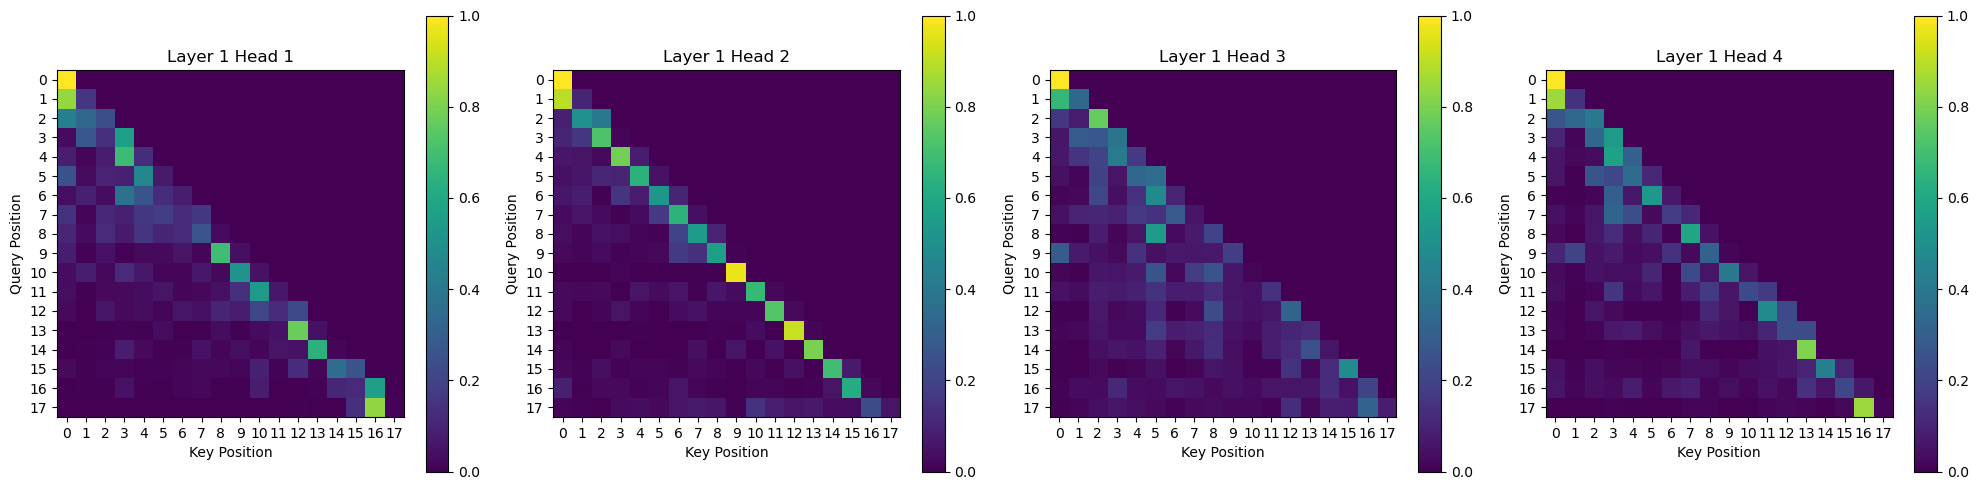

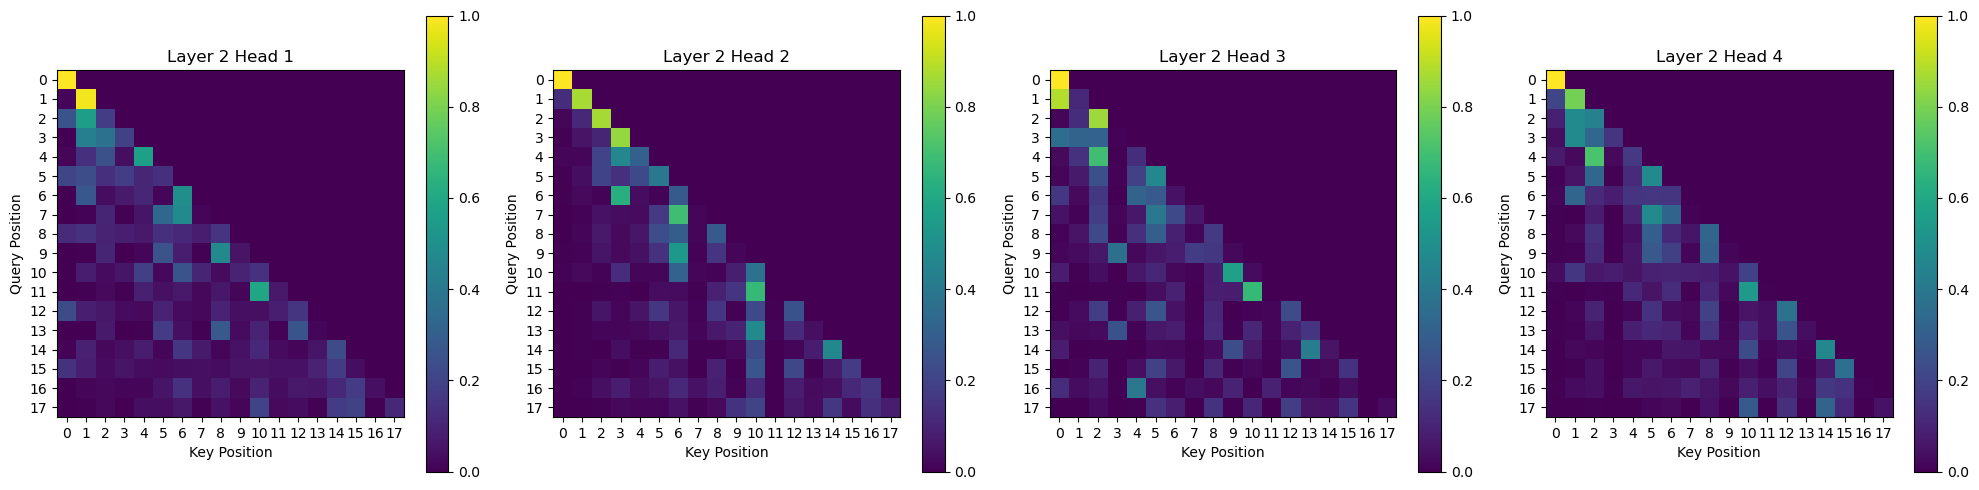

In [37]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

Interpretación de los mapas de calor de atención: 

* Se ve que las primeras posiciones (0 al 3 ó 4) aparecen en tonos claros (amarillos y verdes) lo que indica que el modelo presta mucha atención al inicio de la secuencia. 

* Los colores se hacen oscuros para posiciones más alejadas, lo que implica que la atención se vuelve más difusa para posiciones más alejadas. 

* Todos los heads muestran un comportamiento similar y eso indica que aprenden roles parecidos - no hay evidencia de una especialización fuerte en ninguno de ellos.


### Conclusiones - Task II:

Se realizaron pruebas con Tiny GPT-MoE con 4 expertos con selección de 1 experto por token y se encontró lo siguiente:


Tiempos:

| Modelo          | Tiempo de entrenamiento por época | Tiempo de validación por época |
| --------------- | --------------------------------- | ------------------------------ |
| TinyGPT-MoE     | 38.77 min                         | 0.93 min (≈ 56 s)              |
| TinyGPT (denso) | 5.88 min                          | 0.15 min (≈ 9 s)               |


Performance:

| Modelo          | Training Loss promedio | Validation Loss promedio |
| --------------- | ---------------------- | ------------------------ |
| TinyGPT-MoE     | 1.588                  | 1.6227                   |
| TinyGPT (denso) | 2.116                  | 2.0659                   |


Se observó que:

1. El MoE muestra una pérdida más baja que el modelo original. Sin embargo, la generación sigue siendo incoherente.

2. El comportamiento con los parámetros de generación es similar al del TinyGPT original:
   - Temperatura baja (0) genera texto repetitivo y sin sentido.
   - Temperaturas más altas generan texto más variado pero aún incoherente.
   - top-k y top-p ayudan a mejorar la variedad y estructura del texto generado.
   - La combinación de temperatura alta con top-p parece ofrecer la mejor salida, aunque sigue siendo incoherente.

3. Gráficos de atención: todos los heads muestran un comportamiento similar, y la atención está puesta sobre los primeros caracteres. No parece haber especialización, no atención a largo plazo, algo totalmente esperado dadas las limitaciones de los datos y el modelo. 
Si bien estos gráficos son útiles, no proporcionan información sobre la distribución  de carga/uso de los expertos.

4. Tiempo de entrenamiento: la implementación MoE tardó ~39 mins/época vs ~6 mins/época que presentó el TinyGPT original, algo esperado dado que aunque solo se activa 1 experto por token, durante el forward se calculan todos.

---
#### Conclusiones finales del TP:

* Inicialmente se hicieron pruebas con menos épocas de entrenamiento (2 para ambos modelos, documentadas en la notebook [Otras.ipynb](Otras_pruebas.ipynb)) pero dada la pobre performance se decidió hace un ensayo con mayor cantidad de épocas (10 para TinyGPT y 5 para TinyGPT-MoE). De todas maneras, incrementando las epochs no se observaron mejoras significativas en el desempeño. De hecho, se observa que las pérdidas de entrenamiento y validación se mantienen casi sin cambios.

* El comportamiento de ambos modelos es pobre pero completamente esperado, principalmente debido a que:

    1) El dataset es demasiado pequeño (100k caracteres) - los transformers necesitan grandes cantidades de datos para generalizar bien.

    2) El tokenizer a nivel de caracter es muy rudimentario y limitado.

    3) Modelo pequeño (~10M parámetros) y pocas épocas.
---